#### I got the dataset from Kaggle (https://www.kaggle.com/datasets/alessiocorrado99/animals10)

In [10]:
pip install torch torchvision matplotlib scikit-learn seaborn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [12]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder('/home/eaint/Downloads/archive (1)/animal_cnn/10 animals/train', transform=transform)
test_dataset = datasets.ImageFolder('/home/eaint/Downloads/archive (1)/animal_cnn/10 animals/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes


In [13]:
import torch.nn as nn
import torch.nn.functional as F

class AnimalCNN(nn.Module):
    def __init__(self):
        super(AnimalCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, len(class_names))
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 64x64
        x = self.pool(F.relu(self.conv2(x)))  # 32x32
        x = x.view(-1, 32 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = AnimalCNN()


In [15]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

train_losses, val_losses = [], []

for epoch in range(25):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}") 

Epoch 1, Train Loss: 1.4085, Validation Loss: 1.2768
Epoch 2, Train Loss: 1.3452, Validation Loss: 1.2388
Epoch 3, Train Loss: 1.2854, Validation Loss: 1.1843
Epoch 4, Train Loss: 1.2388, Validation Loss: 1.1380
Epoch 5, Train Loss: 1.1913, Validation Loss: 1.1011
Epoch 6, Train Loss: 1.1598, Validation Loss: 1.0890
Epoch 7, Train Loss: 1.1224, Validation Loss: 1.0872
Epoch 8, Train Loss: 1.0868, Validation Loss: 1.0542
Epoch 9, Train Loss: 1.0616, Validation Loss: 1.0221
Epoch 10, Train Loss: 1.0504, Validation Loss: 1.0693
Epoch 11, Train Loss: 1.0134, Validation Loss: 1.0407
Epoch 12, Train Loss: 0.9941, Validation Loss: 1.0301
Epoch 13, Train Loss: 0.9706, Validation Loss: 1.0100
Epoch 14, Train Loss: 0.9522, Validation Loss: 0.9902
Epoch 15, Train Loss: 0.9325, Validation Loss: 1.0166
Epoch 16, Train Loss: 0.9214, Validation Loss: 1.0334
Epoch 17, Train Loss: 0.8997, Validation Loss: 0.9753
Epoch 18, Train Loss: 0.8920, Validation Loss: 1.0252
Epoch 19, Train Loss: 0.8710, Validat

In [16]:
# Save model state dictionary
torch.save(model.state_dict(), 'animal_classifier.pth')
print("Model saved as animal_classifier.pth")


Model saved as animal_classifier.pth


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Accuracy Score: 0.6846021751574127


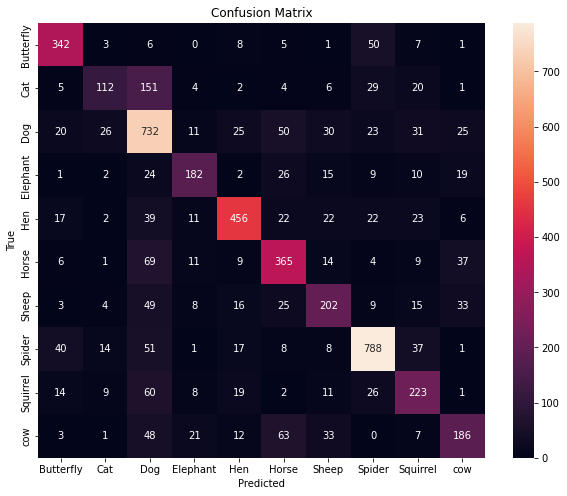

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy Score:", acc)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix1.png")
plt.show()


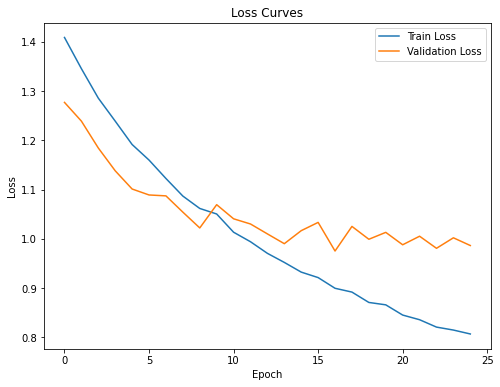

In [18]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss_curves1.png")
plt.show()


In [19]:
with open("results.txt", "w") as f:
    f.write(f"Accuracy: {acc:.4f}\n")
    f.write("Confusion Matrix:\n")
    f.write(np.array2string(cm))


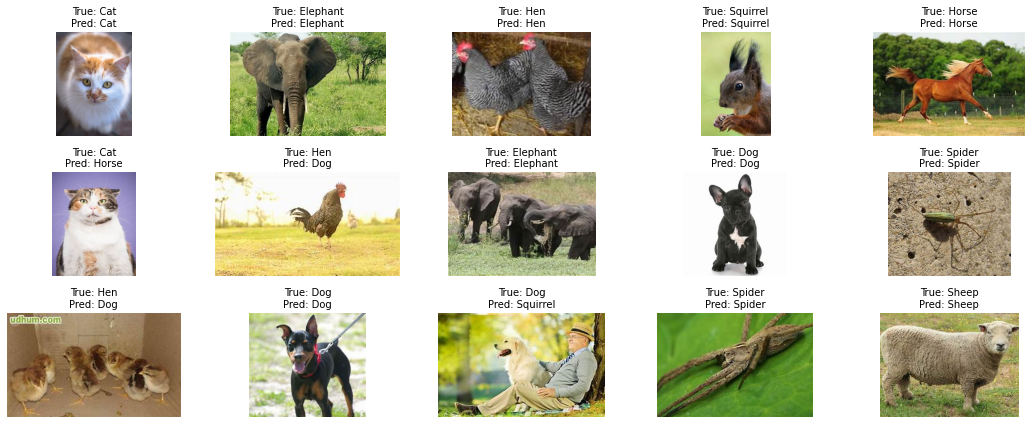

In [26]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import torch

# Your model must already be loaded, and class_names must be defined
# e.g., class_names = ['cat', 'dog', 'horse', ...]
# model = ... (your trained model)
# transform = ... (your transforms.Resize, ToTensor etc.)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def predict_image(image_path, model, transform):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)

    class_name = class_names[predicted.item()]
    return class_name

# === Setup ===
root_dir = '/home/eaint/Downloads/archive (1)/animal_cnn/10 animals/test'
image_labels = []

for label in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, label)
    if not os.path.isdir(class_dir):
        continue
    for img_file in os.listdir(class_dir):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(class_dir, img_file)
            image_labels.append((image_path, label))

# === Random Sampling ===
random.shuffle(image_labels)
sample_images = image_labels[:15]

# === Plotting with Predictions and True Labels ===
fig, axes = plt.subplots(3, 5, figsize=(15, 6))
axes = axes.ravel()

for i, (image_path, true_label) in enumerate(sample_images):
    try:
        img = Image.open(image_path).convert("RGB")
        predicted_label = predict_image(image_path, model, transform)
        axes[i].imshow(img)
        axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)
        axes[i].axis('off')
    except Exception as e:
        print(f"❌ Error loading {image_path}: {e}")

plt.tight_layout()
plt.show()


